In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)

In [2]:
class MC_on():
    """Template for on policy monte carlo agent"""
    
    def __init__(self, shape=(10, 10, 2, 2)):
        
        # q_value : 4d array,  state-action pairs
        # hand_sum * dealer_show * usable_ace * action(hit or stick) => 10 * 10 * 2 * 2
        self.q_values = np.zeros(shape)
        self.n_visits = np.copy(self.q_values)
        self.update_policy()
        
    def update_policy(self):
        # policy : 3d array, boolean value (hit or stick) for each state
        # hand_sum * dealer_show * usable_ace => 10 * 10 * 2
        self.policy = np.argmax(self.q_values, axis=len(self.q_values.shape)-1)
    
    def action(self, state):
        return self.policy[state]
    
    def learn(self, state_actions, returns):
        
        for (s, a), r in zip(state_actions, returns):
            index = *s,a
            self.n_visits[index] += 1
            self.q_values[index] += (1/self.n_visits[index]) * (r - self.q_values[index])
            
        self.update_policy()

In [3]:
class MC_ES(MC_on):
    """Monte Carlo with Exploration Start"""
    
    def __init__(self, shape=(10, 10, 2, 2)):
        super().__init__(shape=shape)
        self.reset()
    
    def reset(self):
        self.start = True
    
    def action(self, state):
        # exploration start
        if self.start:
            self.start = False
            return np.random.choice([0,1])
        else:
            return self.policy[state]

In [4]:
def episode(env, agent, es=True):
    
    if es:
        agent.reset()
    else:
        agent.start = False
    state = env.reset()
    
    # hit immediately if sum < 11
    if state[0] < 11:
        state = env.step(True)[0]
    
    state_actions = []
    rewards = []
    
    # play a full game
    while (True):
        
        state = (
                 state[0]-12, # hand_sum, range 11-32 -> 0 - 21
                 state[1]-1,  # dealer_show, range 1-10 -> 0-9
                 int(state[2]) # usable ace, Bool -> 0 or 1
                )
        
        action = agent.action(state)
        state_actions.append((state, action))
        
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        
        # end episode
        if done:
            break
    
    return state_actions, rewards

In [6]:
EPISODES = 100000
GAMMA = 0.9
env = gym.make('Blackjack-v0')
agent = MC_ES()
mean_rewards = []

for i in range(EPISODES):
    
    state_actions, rewards = episode(env, agent)
    
    # feed transitions to the agent
    g = 0
    returns = []
    for reward in rewards[::-1]:                    # <- NOT COMPLETE to 1st state visit yet, but blackjack is one-way
        g = GAMMA * g + reward
        returns.insert(0, g)
    agent.learn(state_actions, returns)

    # test average reward, without random exploration
    if i % 100 == 0:
        rewards = [episode(env, agent, es=False)[1][-1] for _ in range(500)]
        mean_rewards.append(sum(rewards) / len(rewards))

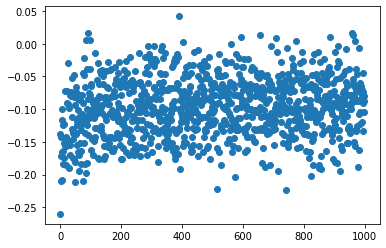

In [7]:
# plotting payoff vs. episodes trained

plt.scatter(range(len(mean_rewards)), mean_rewards);

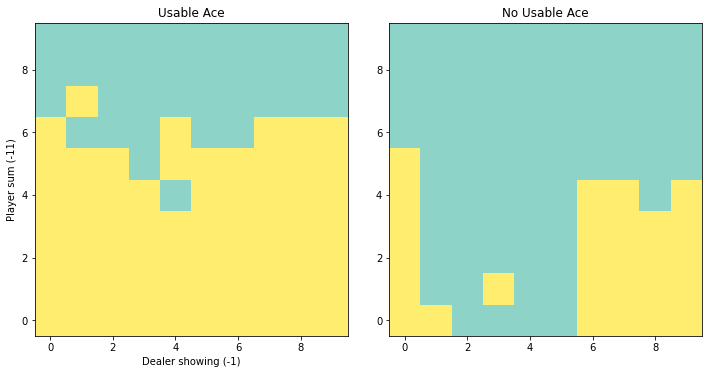

In [8]:
# plotting policy

fig, axs = plt.subplots(1,2, figsize=(10,10))
fig.tight_layout()
axs[0].imshow(agent.policy[:11,:,1], cmap='Set3', origin='lower');
axs[0].set_title("Usable Ace");
axs[0].set_xlabel("Dealer showing (-1)");
axs[0].set_ylabel("Player sum (-11)");
axs[1].imshow(agent.policy[:11,:,0], cmap='Set3', origin='lower');
axs[1].set_title("No Usable Ace");

# => figure 5.2 in Sutton & Barto

In [12]:
class MC_Epsilon(MC_on):
    """Monte Carlo with Soft Epsilon"""
    
    def __init__(self, epsilon=0.2, shape=(10, 10, 2, 2)):
        super().__init__(shape=shape)
        self.test = False
        self.epsilon = epsilon
    
    def action(self, state):
        if not self.test and  np.random.rand() <= self.epsilon:
            return np.random.choice([0,1])
        else:
            return self.policy[state]

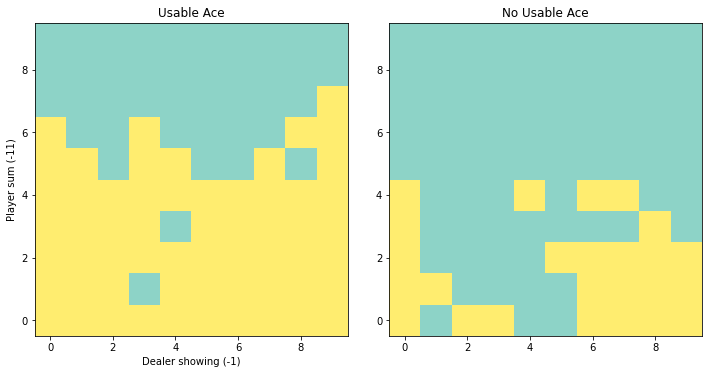

In [13]:
env = gym.make('Blackjack-v0')
agent = MC_Epsilon()
mean_rewards = []

for i in range(EPISODES):
    
    state_actions, rewards = episode(env, agent, es=False)
            
    g = 0
    returns = []
    for reward in rewards[::-1]:
        g = GAMMA * g + reward
        returns.insert(0, g)
    
    agent.learn(state_actions, returns)

    # test average reward, without random exploration
    if i % 100 == 0:
        agent.test = True
        rewards = [episode(env, agent, es=False)[1][-1] for _ in range(500)]
        mean_rewards.append(sum(rewards) / len(rewards))
        agent.test = False
        
fig, axs = plt.subplots(1,2, figsize=(10,10))
fig.tight_layout()
axs[0].imshow(agent.policy[:11,:,1], cmap='Set3', origin='lower');
axs[0].set_title("Usable Ace");
axs[0].set_xlabel("Dealer showing (-1)");
axs[0].set_ylabel("Player sum (-11)");
axs[1].imshow(agent.policy[:11,:,0], cmap='Set3', origin='lower');
axs[1].set_title("No Usable Ace");

In [67]:
class MC_off():
    """Off policy monte carlo agent"""
    
    def __init__(self, shape=(10, 10, 2, 2), gamma=0.9):

        self.shape = shape
        self.gamma = gamma
        
        self.c = np.zeros(shape)
        self.q_values = np.zeros(shape)
        
        self.test_mode = False
        self.update_policy()
        self.reset()
        
    def value_2_policy(self, values):
        # map q value to deterministic argmax policy
        policy = np.argmax(self.q_values, axis=len(self.q_values.shape)-1)
        policy = [[0,1] if x else [1,0] for x in np.nditer(policy)]
        return np.array(policy).reshape(self.shape)
        
    def reset(self):
        # generate random policy
        # guranteed coverage π > 0
        self.behaviour = np.clip(self.value_2_policy(np.random.randn(*self.shape)), 0.01, 0.99)
        self.ratio = self.policy / self.behaviour
        self.test_mode = False
        
    def update_policy(self):
        self.policy = np.clip(self.value_2_policy(self.q_values), 0.01, 0.99) # numerical stability
    
    def action(self, state):
        if self.test_mode:
            return np.argmax(self.policy[state])
        else:
            return np.random.choice([0,1], p=self.behaviour[state])
    
    def learn(self, state_actions, rewards):
        
        # (page110)
        
        g = 0
        w = 1
        
        for (s, a), r in zip(state_actions, rewards):
            index = *s,a
            g = self.gamma * g + r
            self.c[index] += w
            self.q_values[index] += w / self.c[index] * (g - self.q_values[index])
            w *= self.ratio[index]

In [74]:
EPISODES = 100000
env = gym.make('Blackjack-v0')
agent = MC_off()
mean_rewards = []

for i in range(EPISODES):
    
    agent.reset()
    state_actions, rewards = episode(env, agent)
    agent.learn(state_actions, rewards)

    # test average reward, without random exploration
    if i % 100 == 0:
        agent.update_policy()
        agent.test_mode = True
        rewards = [episode(env, agent, es=False)[1][-1] for _ in range(500)]
        mean_rewards.append(sum(rewards) / len(rewards))

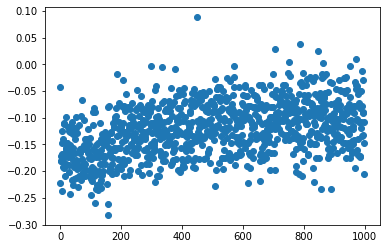

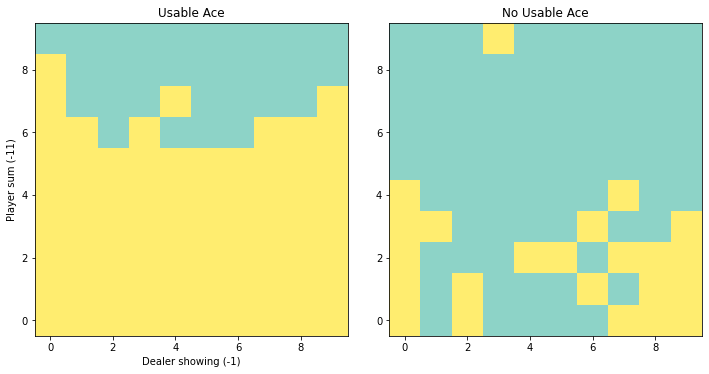

In [75]:
plt.scatter(range(len(mean_rewards)), mean_rewards);

fig, axs = plt.subplots(1,2, figsize=(10,10))
fig.tight_layout()
axs[0].imshow(np.argmax(agent.policy, axis=3)[:11,:,1], cmap='Set3', origin='lower');
axs[0].set_title("Usable Ace");
axs[0].set_xlabel("Dealer showing (-1)");
axs[0].set_ylabel("Player sum (-11)");
axs[1].imshow(np.argmax(agent.policy, axis=3)[:11,:,0], cmap='Set3', origin='lower');
axs[1].set_title("No Usable Ace");